In [5]:
import fitz  # PyMuPDF
from PIL import Image
import pytesseract
import io
import cv2
import numpy as np
import re
import language_tool_python

# Initialize LanguageTool for Spanish
tool = language_tool_python.LanguageTool('es')

# Path to your PDF file
pdf_path = 'books/test2.pdf'

def preprocess_with_opencv(img):
    """
    Preprocess the image using OpenCV, excluding deskewing.
    """
    # Convert to grayscale
    img_gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)
    # Apply Otsu's binarization
    _, img_binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_binary

def detect_page_number(text):
    """
    Detect lines that likely contain page numbers.
    """
    removal_values = []
    lines = text.splitlines()
    for line in lines:
        # Strip leading/trailing whitespace
        stripped_line = line.strip()
        
        # Regex to match patterns like "Page 1", "1 / 100", or numeric-only lines
        if re.match(r"^(page\s*\d+|\d+\s*/\s*\d+|\d+)$", stripped_line, re.IGNORECASE):
            removal_values.append(line)
    
    return removal_values

def clean_text(text):
    """
    Clean the extracted OCR text to remove nonsensical lines and improve output quality,
    while preserving meaningful punctuation.
    """
    # Store the original and cleaned lines in a dictionary
    lines = text.splitlines()
    modified_lines = {}

    for line in lines:
        # Keep the original line
        original_line = line

        # Start with the assumption that the line is clean
        cleaned_line = original_line.strip()

        # Remove lines with mostly non-alphanumeric characters
        if len(re.findall(r'[a-zA-Z0-9]', cleaned_line)) / max(len(cleaned_line), 1) < 0.5:
            cleaned_line = ""

        # Remove lines that are too short (e.g., isolated symbols)
        if len(cleaned_line) < 3:
            cleaned_line = ""

        # Remove excessive repeated characters (e.g., "aaaaaa" or "!!!!")
        if re.match(r"(.)\1{3,}", cleaned_line):
            cleaned_line = ""

        # Keep meaningful punctuation while removing stray symbols
        # Allow common Spanish punctuation and symbols
        cleaned_line = re.sub(r"[^\w\s,.!?¿¡:\"'()-]", "", cleaned_line)

        # If the line changes, store it in the dictionary
        if original_line != cleaned_line:
            modified_lines[original_line] = cleaned_line

    # Replace only the modified lines in the original text
    for original, cleaned in modified_lines.items():
        text = text.replace(original, cleaned)

    return text

def normalize_newlines(text):
    """
    Normalize newline characters:
    - Replace single '\n' with a space.
    - Replace consecutive '\n\n' or more with a single '\n\n'.
    """
    # Replace single newlines surrounded by non-newline characters with a space
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    # Replace multiple newlines with a double newline
    text = re.sub(r"\n{2,}", "\n\n", text)
    return text

def remove_short_lines_in_place(text):
    """
    Remove lines directly from the text that have no words with more than three characters,
    without splitting and rejoining the text.
    :param text: The input text.
    :return: The cleaned text with unwanted lines removed.
    """
    result = []
    start = 0
    length = len(text)
    while start < length:
        # Find the end of the current line
        end = text.find('\n', start)
        if end == -1:
            end = length

        line = text[start:end].strip()
        
        # Determine if the current line ends with a hyphen
        previous_line_ended_with_hyphen = line.endswith("-")

        if previous_line_ended_with_hyphen:
            # Remove the hyphen and concatenate with this line
            result[-1] = result[-1] + line
        else:
            result.append(line)

        

        # Move to the next line
        start = end + 1


    # Reassemble the text from the valid lines in the result
    return "\n".join(result)

# Initialize an empty list to hold the text for each page
pages_text = []

def is_meaningful_text(text, min_length=10, min_alpha_ratio=0.5):
    """
    Check if the text is meaningful based on length and alphanumeric ratio.
    :param text: The text to check.
    :param min_length: Minimum length for the text to be considered meaningful.
    :param min_alpha_ratio: Minimum ratio of alphanumeric characters.
    :return: True if the text is meaningful, False otherwise.
    """
    # Remove whitespace
    stripped_text = text.strip()
    
    # Check length
    if len(stripped_text) < min_length:
        return False
    
    # Check alphanumeric ratio
    alphanumeric_chars = sum(c.isalnum() for c in stripped_text)
    total_chars = len(stripped_text)
    if alphanumeric_chars / max(total_chars, 1) < min_alpha_ratio:
        return False

    return True

# Open the PDF file
with fitz.open(pdf_path) as pdf_document:
    for page_num in range(pdf_document.page_count):
        # Get each page as a pixmap (image)
        page = pdf_document.load_page(page_num)
        pix = page.get_pixmap(dpi=300)

        # Convert pixmap to PIL image
        img = Image.open(io.BytesIO(pix.tobytes("png")))

        # Preprocess the image with OpenCV
        preprocessed_img = preprocess_with_opencv(img)

        # Convert the processed OpenCV image back to a PIL image for Tesseract
        preprocessed_pil_img = Image.fromarray(preprocessed_img)

        # Perform OCR on the preprocessed image using Spanish language
        page_text = pytesseract.image_to_string(preprocessed_pil_img, lang='spa').strip()

        # Detect and remove page numbers
        page_number_text = detect_page_number(page_text)
        if page_number_text is not None:
            for page_number in page_number_text:
                page_text = page_text.replace(page_number, "")

        # Clean nonsensical text
        page_text = clean_text(page_text)
        page_text = normalize_newlines(page_text)
        page_text = remove_short_lines_in_place(page_text)
        page_text = re.sub(r"(\n\n)(.{1,3})(\n\n)", r"\1\3", page_text, flags=re.DOTALL)
        page_text = re.sub(r"\n{3,}", "\n\n", page_text)
        

        # Correct spelling and grammar
        matches = tool.check(page_text)
        corrected_text = language_tool_python.utils.correct(page_text, matches)
        corrected_text = re.sub(r":(.)", r"\1", corrected_text)
        if is_meaningful_text(corrected_text) is True:
            pages_text.append(corrected_text)
        print(f"\n------------------------\n------------------------\nOriginal:\n{page_text}\n------------------------\n------------------------\nFinal:\n{corrected_text}\n##############################\n##############################\n\n")

pages_text


------------------------
------------------------
Original:
dwards bello

joaquin e

biblioeca popular nascimeno

P a Fe
------------------------
------------------------
Final:
Edwards bello

Joaquín e

Biblioteca popular nacimiento

P a Fe
##############################
##############################



------------------------
------------------------
Original:

------------------------
------------------------
Final:

##############################
##############################



------------------------
------------------------
Original:
JOAQUIN EDWARDS BELLO

MITOPOLIS

Introducción de ALFONSO CALDERON

EDITORIAL NASCIMENTO SANTIAGO DE CHILE 1973
------------------------
------------------------
Final:
JOAQUÍN EDWARDS BELLO

METRÓPOLIS

Introducción de ALFONSO CALDERÓN

EDITORIAL NACIMIENTO SANTIAGO DE CHILE 1973
##############################
##############################



------------------------
------------------------
Original:
EXPLICION

Primeramente, este libro se ll

['Edwards bello\n\nJoaquín e\n\nBiblioteca popular nacimiento\n\nP a Fe',
 'JOAQUÍN EDWARDS BELLO\n\nMETRÓPOLIS\n\nIntroducción de ALFONSO CALDERÓN\n\nEDITORIAL NACIMIENTO SANTIAGO DE CHILE 1973',
 'EXPOLICIÓN\n\nPrimeramente, este libro se llamó El Subterráneo de los Jesuitas, timo sugerido por la Editorial Zig-Zag, en reemplazo del original Monopolio, que nació de Joaquín Edwards Bello y que corresponde, verdaderamente, al rastreo temático.\n\nResurge, ahora, con el título genuino. Se ponen en el apéndice, tomados de la prensa, una serie de mitos aplicados, si cabe el término. Es decir, informaciones o crónicas que caen en la zona perceptible de las mentiras adobadas y que, en su momento, registró Joaquín Edwards en su sismógrafo.\n\nNos permitimos reproducir un fragmento de entrevista con J. EB. Parte del material que corresponde a los años 1965 a 1967 y que, en varias oportunidades, completamos con una merengue de artículos y crónicas del escritor y de trozos sueltos, encontrados d

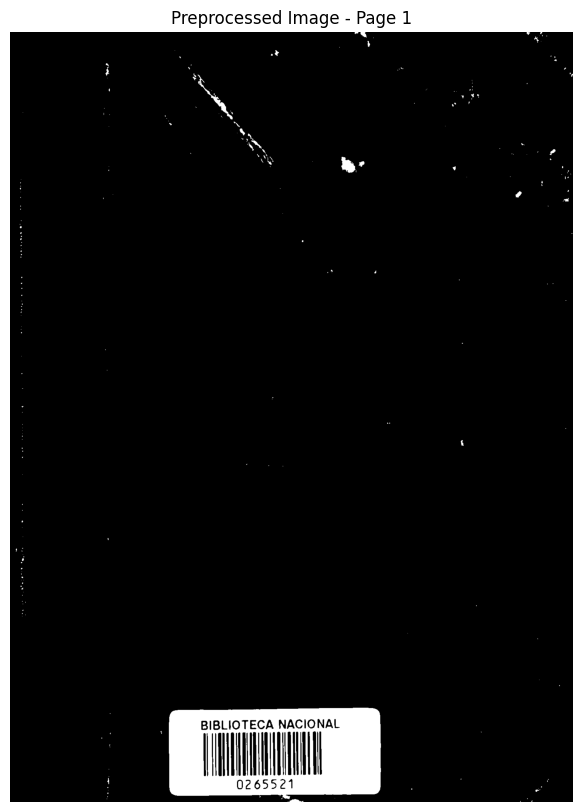

Page 1
Confidence: 46.36%
a  L  Sa,  - Ñ  , ¡mi a  ! 0265521 - -
Page 1 may need manual review (low confidence).


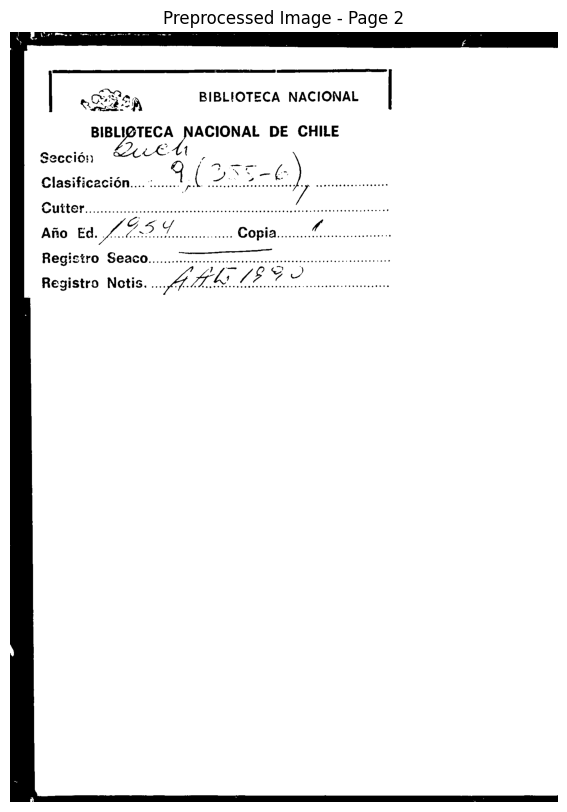

Page 2
Confidence: 57.05%
l DN BIBLIOTECA NACIONAL  BIBLIOTECA NACIONAL DE CHILE   Sección AAN o.   Clasificación... Ll 275-6) einen   Año ELE Leen. Copia...   Registro Seaco......... es   Registro Notis. ALLE TL nano
Page 2 may need manual review (low confidence).


KeyboardInterrupt: 

In [12]:
import os
import fitz  # PyMuPDF for PDF handling
import cv2
import pytesseract
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from spellchecker import SpellChecker  # For post-processing

# Access the tesseract path
os.getenv('TESSDATA_PREFIX')


def preprocess_image(image):
    """
    Preprocess the image using a dynamic approach:
    - Use the old method for simpler pages.
    - Use the newer method for complex or low-contrast pages.
    """
    # Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(grayscale, (5, 5), 0)

    # Apply Otsu's binarization
    _, img_binary = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return img_binary

# OCR function with confidence scoring
def extract_text(image):
    """
    Extracts text and confidence scores from a preprocessed image using Tesseract OCR.
    """
    config = (
    "--oem 1 --psm 6 "
    "-c tessedit_char_whitelist=' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZáéíóúÁÉÍÓÚñÑ,.¡!¿?\\\"\\'():;-1234567890 "
)
    data = pytesseract.image_to_data(image, lang="spa", config=config, output_type=pytesseract.Output.DICT)
    
    text = " ".join(data["text"]).strip()
    confidence = np.mean([conf for conf in data["conf"] if conf > 0])  # Ignore invalid (-1) confidence values
    return text, confidence

# Post-processing function
def postprocess_text(text):
    """
    Cleans and corrects OCR text using spell-checking and basic formatting.
    """
    spell = SpellChecker(language="es")  # Spanish spell checker
    words = text.split()
    corrected_words = [
        spell.correction(word) if spell.correction(word) else word for word in words
    ]
    return " ".join(corrected_words)

# Title/Paragraph Detection (PyTorch placeholder)
def detect_text_regions(image):
    """
    Placeholder function to detect titles, paragraphs, or regions using PyTorch.
    You can expand this with pre-trained models for layout detection like Detectron2.
    """
    # Example: Mock segmentation with PyTorch transforms (future Detectron2 integration)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_image = transform(image)
    # Add PyTorch-based segmentation logic here
    return tensor_image  # Return for demonstration (expand as needed)

# Main pipeline to process a PDF
def process_pdf(pdf_path):
    """
    Extracts text from each page of a scanned book PDF and saves it to text files.
    """
    with fitz.open(pdf_path) as pdf_document:
        for page_num in range(pdf_document.page_count):
            # Load page as an image
            page = pdf_document.load_page(page_num)
            pix = page.get_pixmap(dpi=300)  # High-resolution image for OCR
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            
            # Convert PIL image to OpenCV format
            open_cv_image = np.array(img)[:, :, ::-1]  # Convert RGB to BGR for OpenCV

            # Preprocess the image
            preprocessed_image = preprocess_image(open_cv_image)

            # Display the preprocessed image (for debugging)
            plt.figure(figsize=(10, 10))
            plt.imshow(preprocessed_image, cmap="gray")
            plt.title(f"Preprocessed Image - Page {page_num + 1}")
            plt.axis("off")
            plt.show()

            # Detect regions (placeholder)
            _ = detect_text_regions(preprocessed_image)

            # Extract text and confidence
            text, confidence = extract_text(preprocessed_image)

            # Post-process text
            #cleaned_text = postprocess_text(text)

            # Print text and confidence
            print(f"Page {page_num + 1}")
            print(f"Confidence: {confidence:.2f}%")
            print(text)

            # Flag for review if confidence is below threshold
            if confidence < 80:  # Adjust threshold as needed
                print(f"Page {page_num + 1} may need manual review (low confidence).")

# Example usage
pdf_path = "books/test4.pdf"  # Path to your PDF
process_pdf(pdf_path)

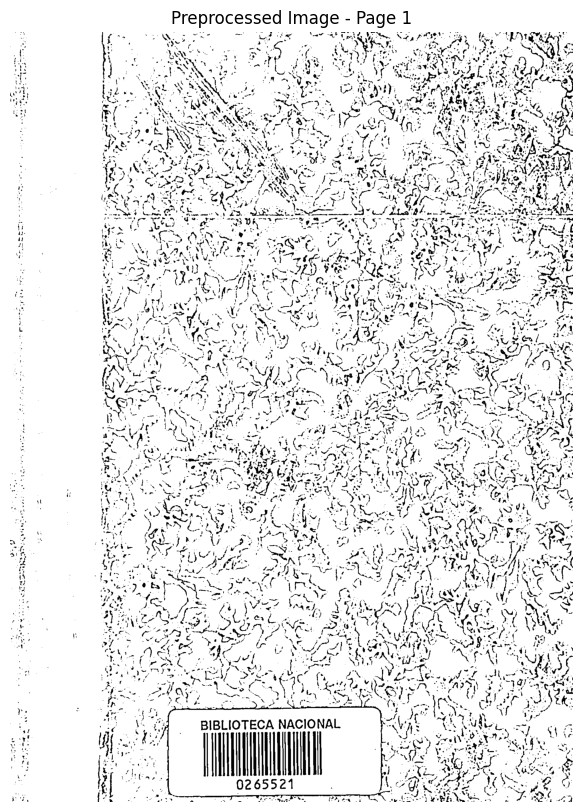

Page 1
Confidence: 35.50%
NET E, T. A LE Ea par  UA VIT VI TO SETA E EZ  .. o Im o TEN TND OL TRI, ) -  fo. NN E. A 8 e SE EP ÍA un R  - E. Ne St O Poo ON CA Ro  - Poo AN NN ye ur De Po e ES e E A te e -  f le ZA A Sr O STA ES y  . 82. el e LA A. E Ne - NT De 06 sE e  : AE E OA SC NTE a o  l l S en A PA A VAT EAT A a LA EA PU 2  a E - - -. ; LEA A j e o  E. ORTA Eo 7 A 7  u NO A AS NL STE Eo ee DEA Nes e  - 1 pe e - a, , YX  el 7. DA vu E (Oi NUNCA Lo OZ e, E N A  AS CEE E UT ALE Y Ca le  e AA - Te TN NA n de Ta  DIVA TRAS A) Ke 1er CN AR aq mé  ; DU, EN LIE - Ti ¡E E o LO 4 al CA IS  5 bos 27 N Mo E PAS O DD NE Fa) t NANA L  f De: Eo ENERO 2 Mena NT  CEN Ms E TÁ Na CN ANS Ap 7 7  ET Ne NI -. Me. A E, Dep A INT T 1h f Tur 7  o ME To i de pul q a A  E ¡e ñ E 7 Ae Na , TO ms A a A  a PE D Un 45 77 o A USDA 7 - e a  A UN ACA Vo ON en BN La í 7  Ls ZA DT LN 7 Tu q DA CIO "7 Nu  - e ON - in N 1 1 EL Za Co LR ! Ea Ea e  y Da K- EL) SNA E ENT N E e  - E CN e NAL NA NA Ns,  Pes BLIOTE! LA an d

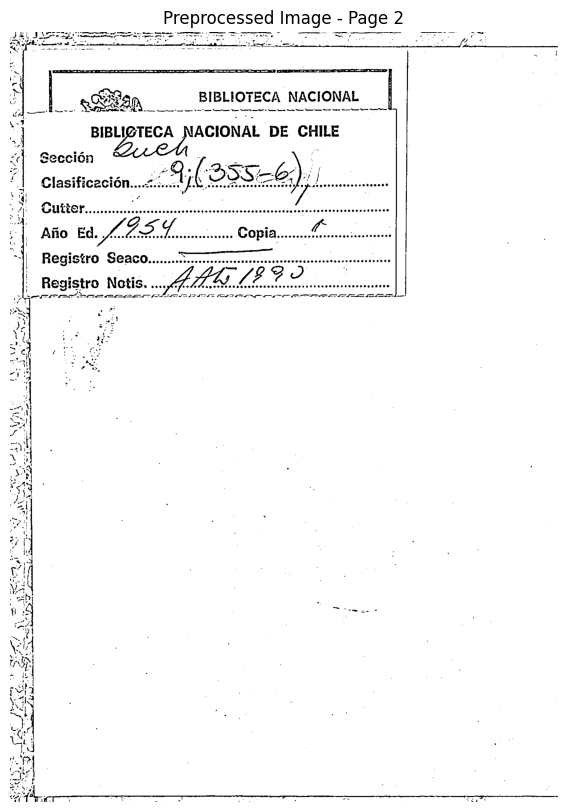

Page 2
Confidence: 48.64%
- "E" ¿Sian merioreca nacionar  3 No  a BIBLIGTECA NACIONAL DE CHILE  1 Sección ; 0  - ción. OSO)  . Año Ed llama Copia... ecrenins  - Registro Seaco......................emmeeneiee enn   . Registro Notis. fl BA Laa  7 Jean OL 4 2ELILZ2 1z4 4247 44 -IADLIIZL- LLL 090  E e.  7 .  A .
Page 2 may need manual review (low confidence).


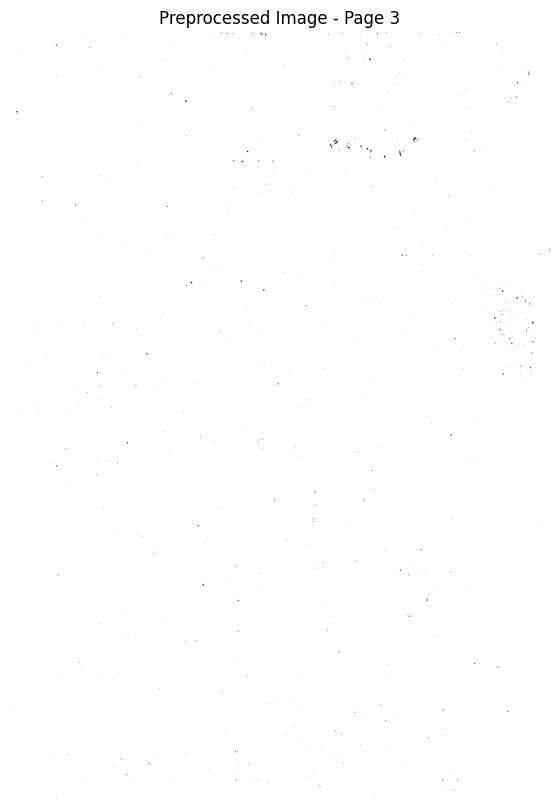

Page 3
Confidence: 65.00%
- a
Page 3 may need manual review (low confidence).


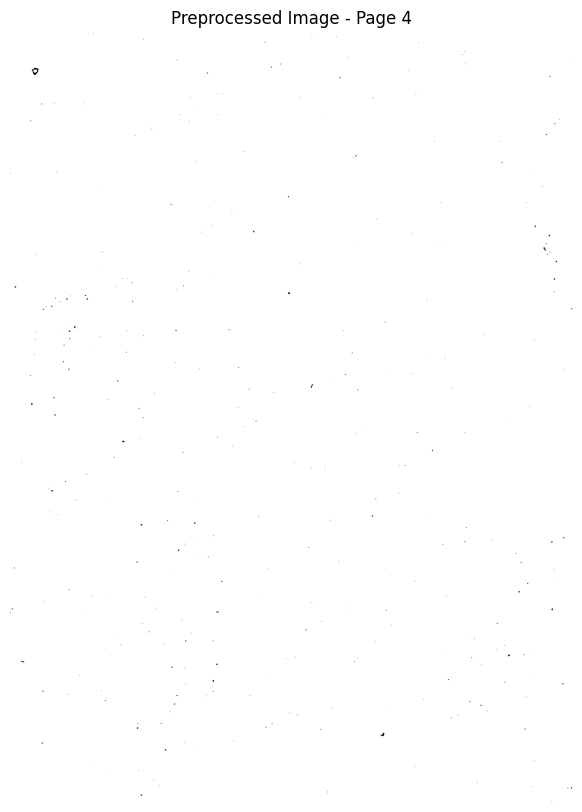

Page 4
Confidence: 54.50%
LR  LA  -
Page 4 may need manual review (low confidence).


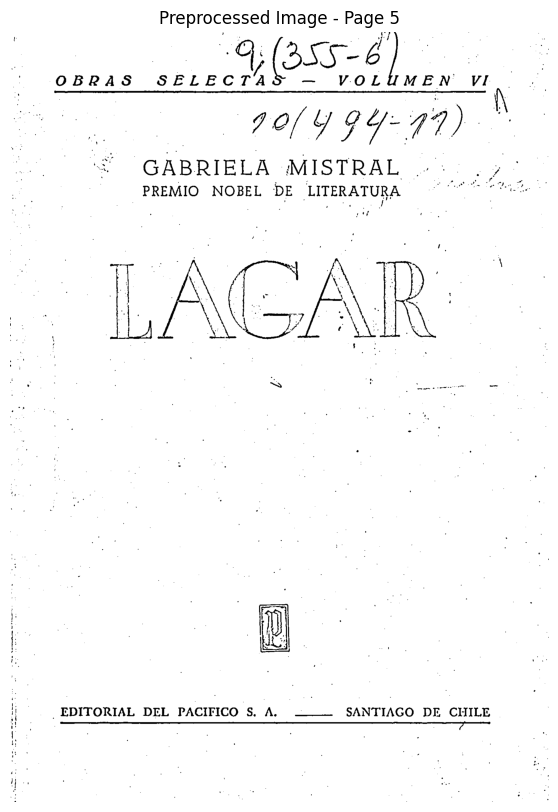

Page 5
Confidence: 69.04%
l Y (355-6 e  Ñ OBRAS SELECTA - VOL MEN AN o  o 7077 97-77) o  -. GABRIELA MISTRAL .. .7.  PREMIO NOBEL DE LITERATURA  EDITORIAL DEL PACIFICO S. A. SANTIAGO DE CHILE l
Page 5 may need manual review (low confidence).


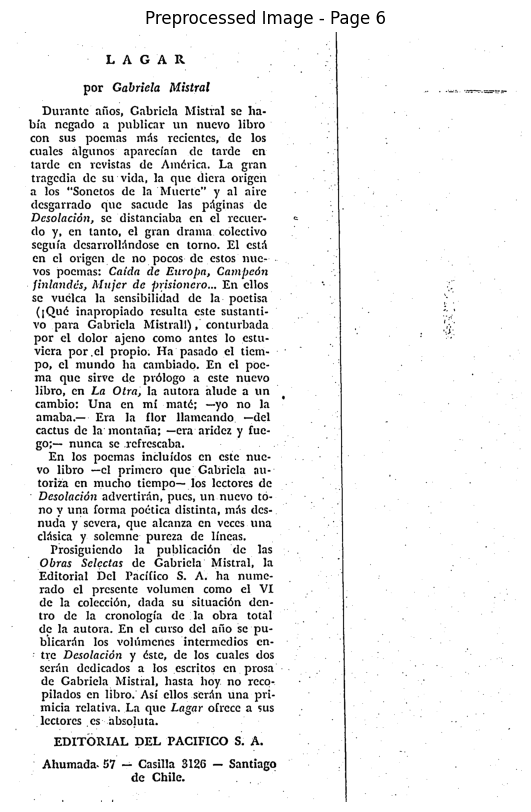

Page 6
Confidence: 77.50%
- - LAGAR - o  por Gabriela Mistral as  Durante años, Gabricla Mistral se ha- o  bía negado a publicar un nuevo libro - -. o  con sus pocmas más recientes, de los . - -  cuales álgunos aparecian de tarde en 7  tarde en revistas de América, La gran : 7  tragedia de su-vida, la que diera origen  a los "Sonetos de la Mucrte" y al aire 7 a  desgarrado que sacude las páginas de .  Desolación, se distanciaba en el recuer- e - .  do y, en tanto, el gran drama. colectivo o  seguía desarrollándose en torno. El está  en cl origen de no pocos: de estos nue- . o e.  vos poemas: Caida de Europa, Campeón ,  - finlandes, Mujer de prisionero... En cllos ; a !  se vuelca la sensibilidad de la. poetisa N .  (¡Qué inapropiado resulta este sustanti-  . . - o  vo para Gabricla Mistral!), conturbada odo, us !  por el dolor ajeno como antes lo estu- o - a.  viera porel propio. Ha pasado el tiem- - - - !  po, el mundo ha cambiado. En el poc- u o  ma que sirve de prólogo a este nuevo 

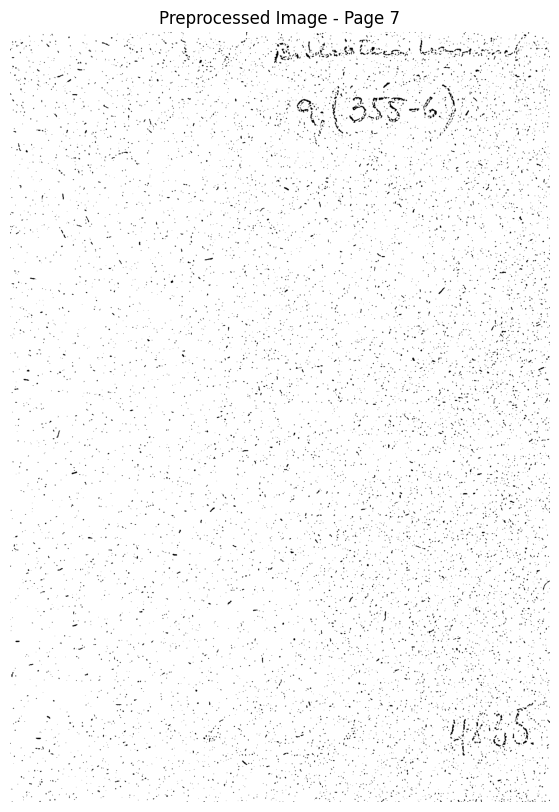

Page 7
Confidence: 33.91%
TEN - o PU O AA e: 5 Aire ems LeT NA TEE  e N N . E 3 . ea NP BA Ta EA  MO ... e A A REL o. o - : E A es
Page 7 may need manual review (low confidence).


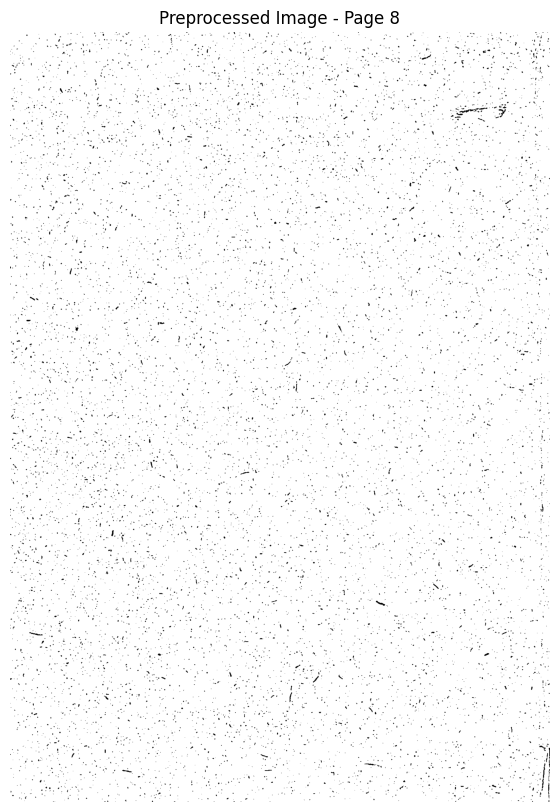

/Users/christianguerra/code/spanish-book-ocr/venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/christianguerra/code/spanish-book-ocr/venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Page 8
Confidence: nan%



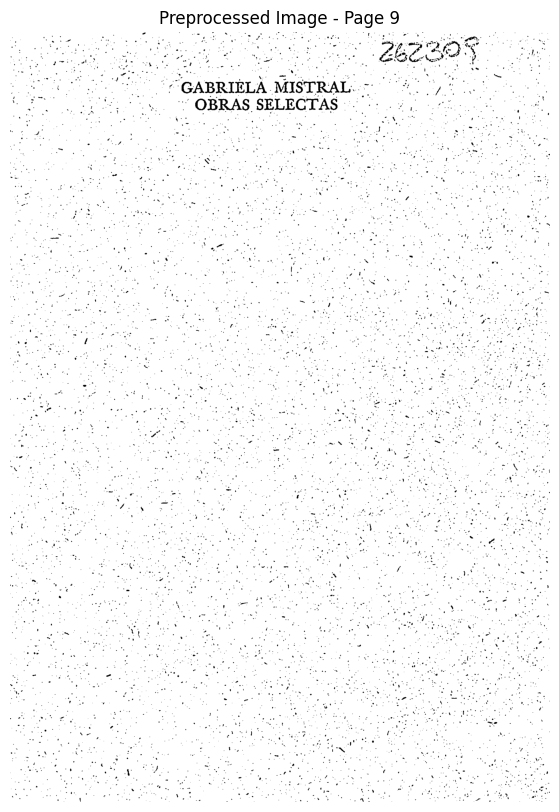

KeyboardInterrupt: 

In [13]:
import os
import fitz  # PyMuPDF for PDF handling
import cv2
import pytesseract
from PIL import Image
import numpy as np
import io
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from spellchecker import SpellChecker  # For post-processing

# Access the tesseract path
os.getenv('TESSDATA_PREFIX')


def preprocess_image(image):
    """
    Preprocesses an image for OCR by removing noise, normalizing the background,
    and enhancing text regions while preserving contrast.
    """
    # Step 1: Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur
    img_blur = cv2.GaussianBlur(grayscale, (5, 5), 0)

    # Step 4: Enhance contrast using CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(img_blur)

    # Step 5: Denoise using median blur (preserve edges)
    denoised = cv2.medianBlur(enhanced, 3)

    # Step 6: Apply adaptive thresholding for binarization
    binarized = cv2.adaptiveThreshold(
        denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 10
    )

    return binarized

# OCR function with confidence scoring
def extract_text(image):
    """
    Extracts text and confidence scores from a preprocessed image using Tesseract OCR.
    """
    config = (
    "--oem 1 --psm 6 "
    "-c tessedit_char_whitelist=' abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZáéíóúÁÉÍÓÚñÑ,.¡!¿?\\\"\\'():;-1234567890 "
)
    data = pytesseract.image_to_data(image, lang="spa", config=config, output_type=pytesseract.Output.DICT)
    
    text = " ".join(data["text"]).strip()
    confidence = np.mean([conf for conf in data["conf"] if conf > 0])  # Ignore invalid (-1) confidence values
    return text, confidence

# Post-processing function
def postprocess_text(text):
    """
    Cleans and corrects OCR text using spell-checking and basic formatting.
    """
    spell = SpellChecker(language="es")  # Spanish spell checker
    words = text.split()
    corrected_words = [
        spell.correction(word) if spell.correction(word) else word for word in words
    ]
    return " ".join(corrected_words)

# Title/Paragraph Detection (PyTorch placeholder)
def detect_text_regions(image):
    """
    Placeholder function to detect titles, paragraphs, or regions using PyTorch.
    You can expand this with pre-trained models for layout detection like Detectron2.
    """
    # Example: Mock segmentation with PyTorch transforms (future Detectron2 integration)
    transform = transforms.Compose([transforms.ToTensor()])
    tensor_image = transform(image)
    # Add PyTorch-based segmentation logic here
    return tensor_image  # Return for demonstration (expand as needed)

# Main pipeline to process a PDF
def process_pdf(pdf_path):
    """
    Extracts text from each page of a scanned book PDF and saves it to text files.
    """
    with fitz.open(pdf_path) as pdf_document:
        for page_num in range(pdf_document.page_count):
            # Load page as an image
            page = pdf_document.load_page(page_num)
            pix = page.get_pixmap(dpi=300)  # High-resolution image for OCR
            img = Image.open(io.BytesIO(pix.tobytes("png")))
            
            # Convert PIL image to OpenCV format
            open_cv_image = np.array(img)[:, :, ::-1]  # Convert RGB to BGR for OpenCV

            # Preprocess the image
            preprocessed_image = preprocess_image(open_cv_image)

            # Display the preprocessed image (for debugging)
            plt.figure(figsize=(10, 10))
            plt.imshow(preprocessed_image, cmap="gray")
            plt.title(f"Preprocessed Image - Page {page_num + 1}")
            plt.axis("off")
            plt.show()

            # Detect regions (placeholder)
            _ = detect_text_regions(preprocessed_image)

            # Extract text and confidence
            text, confidence = extract_text(preprocessed_image)

            # Post-process text
            #cleaned_text = postprocess_text(text)

            # Print text and confidence
            print(f"Page {page_num + 1}")
            print(f"Confidence: {confidence:.2f}%")
            print(text)

            # Flag for review if confidence is below threshold
            if confidence < 80:  # Adjust threshold as needed
                print(f"Page {page_num + 1} may need manual review (low confidence).")

# Example usage
pdf_path = "books/test4.pdf"  # Path to your PDF
process_pdf(pdf_path)